# 1. Imports

In [1]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as transforms

# Library for augmentations
import albumentations as A

# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

# 2. Augmentations

In [3]:
def train_transform():
    return A.Compose([
        A.Sequential([
            # Random rotation
            A.augmentations.geometric.rotate.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1),
            # Random change of brightness and contrast
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1),
        ], p=1)
    ],
    # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    keypoint_params=A.KeypointParams(format='xy'),
    # Bboxes should have labels, read more here https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels'])
    )

# 3. Dataset class

In [6]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.demo = demo
        self.imgs_files = sorted(os.listdir(os.path.join(root, 'images')))
        self.annotations_files = sorted(os.listdir(os.path.join(root, 'annotations')))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs_files[idx])
        annotations_path = os.path.join(self.root, 'annotations', self.annotations_files[idx])

        img_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are car wheels
            bboxes_labels_original = ['Car wheel' for _ in bboxes_original]            

        if self.transform:   
            # Converting keypoints from [x, y, visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2, obj1_kp3], [obj2_kp1, obj2_kp2, obj2_kp3], [obj3_kp1, obj3_kp2, obj3_kp3]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj1_kp3, obj2_kp1, obj2_kp2, obj2_kp3, obj3_kp1, obj3_kp2, obj3_kp3]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]

            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj1_kp3, obj2_kp1, obj2_kp2, obj2_kp3, obj3_kp1, obj3_kp2, obj3_kp3], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2, obj1_kp3], [obj2_kp1, obj2_kp2, obj2_kp3], [obj3_kp1, obj3_kp2, obj3_kp3]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1, 3, 2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x, y, visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target['boxes'] = bboxes
        # All objects are car wheels
        target['labels'] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64)
        target['image_id'] = torch.tensor([idx])
        target['area'] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target['iscrowd'] = torch.zeros(len(bboxes), dtype=torch.int64)
        target['keypoints'] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original['boxes'] = bboxes_original
        # All objects are car wheels
        target_original['labels'] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64)
        target_original['image_id'] = torch.tensor([idx])
        target_original['area'] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original['iscrowd'] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original['keypoints'] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

# 4. Visualizing a random item from dataset

In [9]:
keypoints_classes_ids2names = {0: 'Top', 1: 'Bottom', 2: 'Right'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18
    
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if image_original is not None:
        image_original = cv2.cvtColor(image_original, cv2.COLOR_GRAY2RGB)

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), ' ' + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, ' ' + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

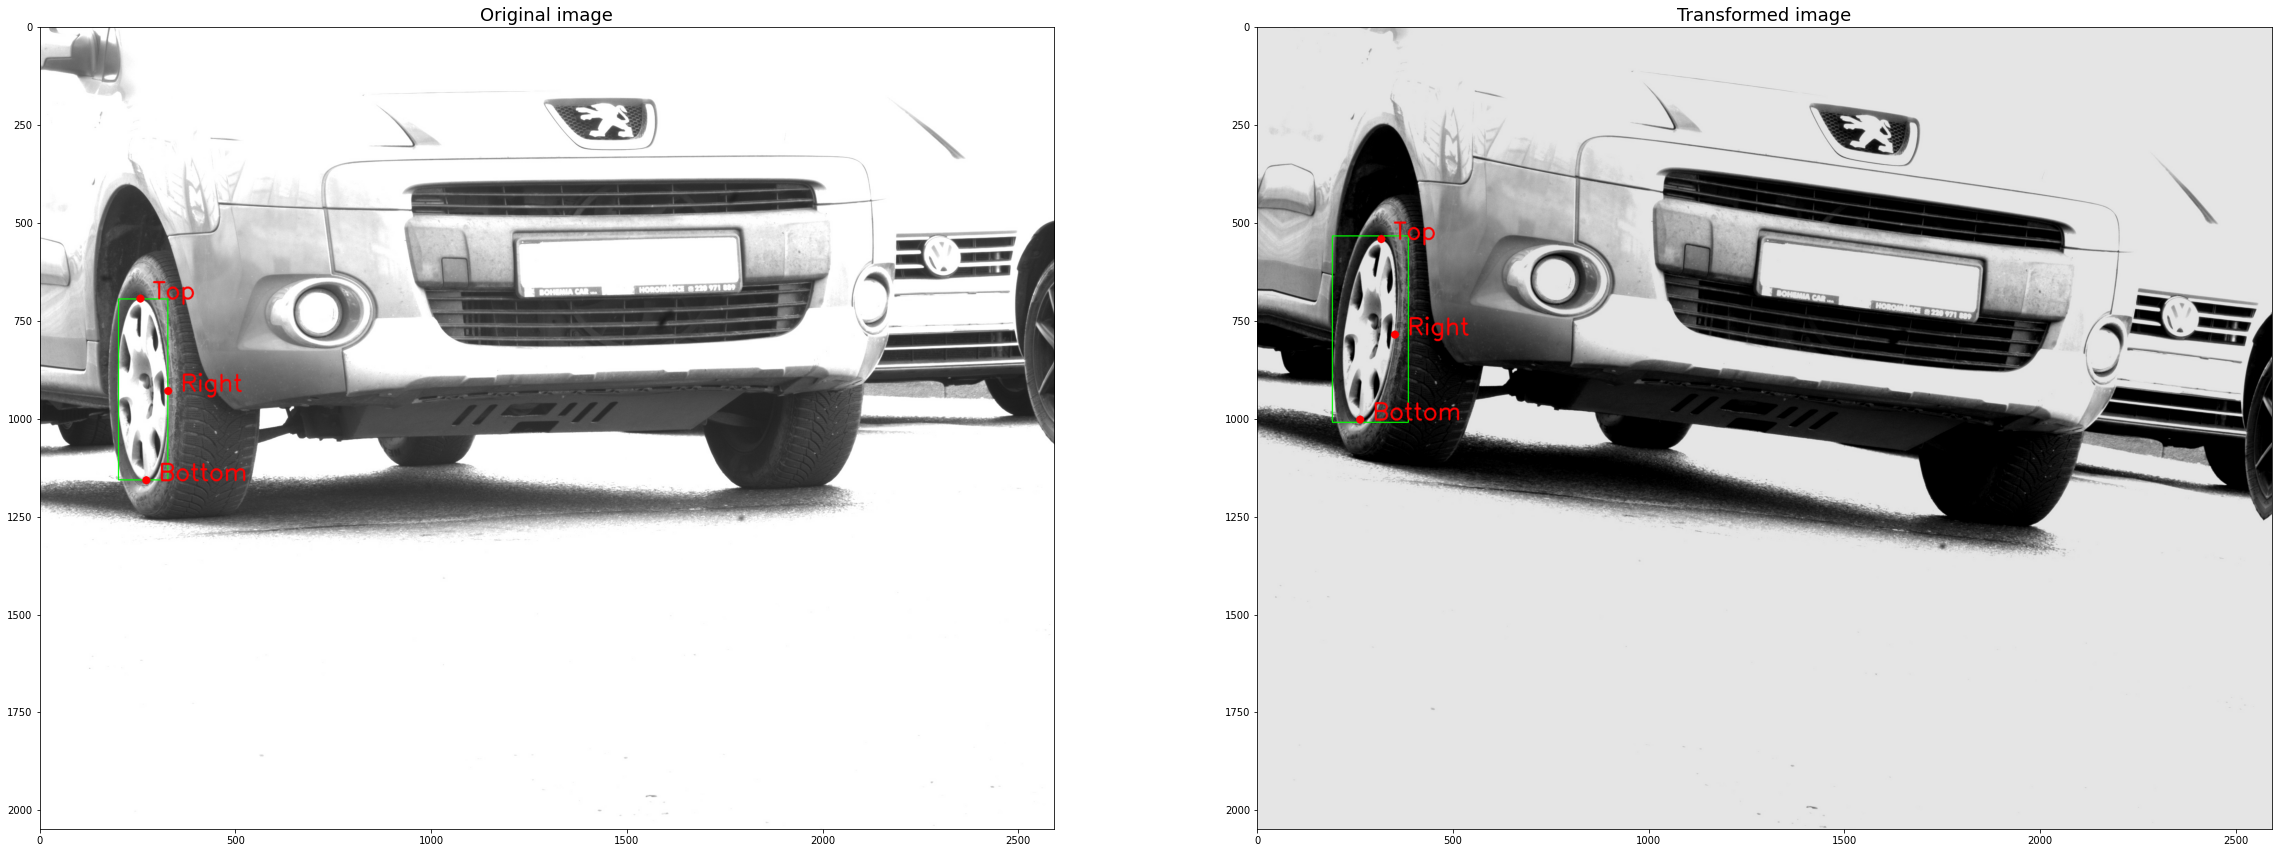

In [16]:
KEYPOINTS_FOLDER_TRAIN = 'dataset/train'
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)    
    
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

# 5. Training

In [18]:
def get_model(num_keypoints, weights_path=None):
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   # One class for car wheel, one class for background
                                                                   num_classes=2,
                                                                   rpn_anchor_generator=anchor_generator)
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = 'dataset/train'
KEYPOINTS_FOLDER_TEST = 'dataset/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints=3)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    
# Save model weights after training
torch.save(model.state_dict(), 'saved_model.pth')

/home/daniel/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [ 0/29]  eta: 0:00:07  lr: 0.000037  loss: 9.5437 (9.5437)  loss_classifier: 0.7236 (0.7236)  loss_box_reg: 0.0000 (0.0000)  loss_keypoint: 8.1234 (8.1234)  loss_objectness: 0.6935 (0.6935)  loss_rpn_box_reg: 0.0033 (0.0033)  time: 0.2589  data: 0.0628  max mem: 965
Epoch: [0]  [28/29]  eta: 0:00:00  lr: 0.001000  loss: 7.9015 (8.5121)  loss_classifier: 0.1615 (0.3433)  loss_box_reg: 0.0166 (0.0243)  loss_keypoint: 7.1124 (7.4572)  loss_objectness: 0.6691 (0.6762)  loss_rpn_box_reg: 0.0097 (0.0110)  time: 0.2307  data: 0.0568  max mem: 1602
Epoch: [0] Total time: 0:00:06 (0.2318 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:02  model_time: 0.1665 (0.1665)  evaluator_time: 0.0089 (0.0089)  time: 0.2234  data: 0.0445  max mem: 1602
Test:  [8/9]  eta: 0:00:00  model_time: 0.1628 (0.1633)  evaluator_time: 0.0078 (0.0082)  time: 0.2208  data: 0.0453  max mem: 1602
Test: Total time: 0:00:01 (0.2209 s / it)
Averaged stats: model_time: 0.1628 (0.1633)  evaluator_

Epoch: [3]  [ 0/29]  eta: 0:00:06  lr: 0.001000  loss: 6.2667 (6.2667)  loss_classifier: 0.0521 (0.0521)  loss_box_reg: 0.0001 (0.0001)  loss_keypoint: 6.0257 (6.0257)  loss_objectness: 0.1799 (0.1799)  loss_rpn_box_reg: 0.0090 (0.0090)  time: 0.2247  data: 0.0359  max mem: 1602
Epoch: [3]  [28/29]  eta: 0:00:00  lr: 0.001000  loss: 7.0206 (7.1987)  loss_classifier: 0.0594 (0.0704)  loss_box_reg: 0.0327 (0.0426)  loss_keypoint: 6.7373 (6.9689)  loss_objectness: 0.0701 (0.1088)  loss_rpn_box_reg: 0.0046 (0.0079)  time: 0.2284  data: 0.0498  max mem: 1602
Epoch: [3] Total time: 0:00:06 (0.2306 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1618 (0.1618)  evaluator_time: 0.0080 (0.0080)  time: 0.2206  data: 0.0473  max mem: 1602
Test:  [8/9]  eta: 0:00:00  model_time: 0.1638 (0.1625)  evaluator_time: 0.0081 (0.0085)  time: 0.2232  data: 0.0488  max mem: 1602
Test: Total time: 0:00:02 (0.2233 s / it)
Averaged stats: model_time: 0.1638 (0.1625)  evaluator

Epoch: [6]  [ 0/29]  eta: 0:00:07  lr: 0.000300  loss: 6.1263 (6.1263)  loss_classifier: 0.1062 (0.1062)  loss_box_reg: 0.0722 (0.0722)  loss_keypoint: 5.8761 (5.8761)  loss_objectness: 0.0618 (0.0618)  loss_rpn_box_reg: 0.0100 (0.0100)  time: 0.2433  data: 0.0362  max mem: 1602
Epoch: [6]  [28/29]  eta: 0:00:00  lr: 0.000300  loss: 6.5301 (6.5405)  loss_classifier: 0.0573 (0.0724)  loss_box_reg: 0.0418 (0.0578)  loss_keypoint: 6.2527 (6.3280)  loss_objectness: 0.0606 (0.0740)  loss_rpn_box_reg: 0.0067 (0.0084)  time: 0.2336  data: 0.0532  max mem: 1602
Epoch: [6] Total time: 0:00:06 (0.2350 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1092 (0.1092)  evaluator_time: 0.0034 (0.0034)  time: 0.1634  data: 0.0473  max mem: 1602
Test:  [8/9]  eta: 0:00:00  model_time: 0.1092 (0.1083)  evaluator_time: 0.0040 (0.0038)  time: 0.1638  data: 0.0481  max mem: 1602
Test: Total time: 0:00:01 (0.1639 s / it)
Averaged stats: model_time: 0.1092 (0.1083)  evaluator

Epoch: [9]  [ 0/29]  eta: 0:00:07  lr: 0.000300  loss: 4.9665 (4.9665)  loss_classifier: 0.1277 (0.1277)  loss_box_reg: 0.0851 (0.0851)  loss_keypoint: 4.7326 (4.7326)  loss_objectness: 0.0197 (0.0197)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 0.2508  data: 0.0361  max mem: 1602
Epoch: [9]  [28/29]  eta: 0:00:00  lr: 0.000300  loss: 5.8171 (5.7462)  loss_classifier: 0.0647 (0.0805)  loss_box_reg: 0.0824 (0.0927)  loss_keypoint: 5.6241 (5.5274)  loss_objectness: 0.0373 (0.0394)  loss_rpn_box_reg: 0.0041 (0.0063)  time: 0.2542  data: 0.0559  max mem: 1602
Epoch: [9] Total time: 0:00:07 (0.2535 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1516 (0.1516)  evaluator_time: 0.0078 (0.0078)  time: 0.2109  data: 0.0480  max mem: 1602
Test:  [8/9]  eta: 0:00:00  model_time: 0.1221 (0.1249)  evaluator_time: 0.0051 (0.0056)  time: 0.1819  data: 0.0480  max mem: 1602
Test: Total time: 0:00:01 (0.1820 s / it)
Averaged stats: model_time: 0.1221 (0.1249)  evaluator

Epoch: [12]  [ 0/29]  eta: 0:00:06  lr: 0.000090  loss: 4.9092 (4.9092)  loss_classifier: 0.0438 (0.0438)  loss_box_reg: 0.0561 (0.0561)  loss_keypoint: 4.7620 (4.7620)  loss_objectness: 0.0445 (0.0445)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 0.2271  data: 0.0637  max mem: 1602
Epoch: [12]  [28/29]  eta: 0:00:00  lr: 0.000090  loss: 5.4216 (5.3142)  loss_classifier: 0.0844 (0.0734)  loss_box_reg: 0.0877 (0.1020)  loss_keypoint: 5.0915 (5.0944)  loss_objectness: 0.0322 (0.0385)  loss_rpn_box_reg: 0.0057 (0.0060)  time: 0.2442  data: 0.0485  max mem: 1602
Epoch: [12] Total time: 0:00:07 (0.2417 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1439 (0.1439)  evaluator_time: 0.0068 (0.0068)  time: 0.2023  data: 0.0464  max mem: 1602
Test:  [8/9]  eta: 0:00:00  model_time: 0.1206 (0.1216)  evaluator_time: 0.0053 (0.0053)  time: 0.1793  data: 0.0486  max mem: 1602
Test: Total time: 0:00:01 (0.1794 s / it)
Averaged stats: model_time: 0.1206 (0.1216)  evalua

Epoch: [15]  [ 0/29]  eta: 0:00:07  lr: 0.000027  loss: 5.5914 (5.5914)  loss_classifier: 0.1211 (0.1211)  loss_box_reg: 0.2000 (0.2000)  loss_keypoint: 5.2329 (5.2329)  loss_objectness: 0.0324 (0.0324)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 0.2720  data: 0.0528  max mem: 1602
Epoch: [15]  [28/29]  eta: 0:00:00  lr: 0.000027  loss: 4.8712 (5.0900)  loss_classifier: 0.0453 (0.0653)  loss_box_reg: 0.0551 (0.0985)  loss_keypoint: 4.7156 (4.8821)  loss_objectness: 0.0267 (0.0372)  loss_rpn_box_reg: 0.0042 (0.0068)  time: 0.2495  data: 0.0550  max mem: 1602
Epoch: [15] Total time: 0:00:07 (0.2483 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1280 (0.1280)  evaluator_time: 0.0050 (0.0050)  time: 0.1827  data: 0.0462  max mem: 1602
Test:  [8/9]  eta: 0:00:00  model_time: 0.1106 (0.1128)  evaluator_time: 0.0044 (0.0046)  time: 0.1702  data: 0.0493  max mem: 1602
Test: Total time: 0:00:01 (0.1703 s / it)
Averaged stats: model_time: 0.1106 (0.1128)  evalua

Epoch: [18]  [ 0/29]  eta: 0:00:07  lr: 0.000027  loss: 4.3266 (4.3266)  loss_classifier: 0.0320 (0.0320)  loss_box_reg: 0.0578 (0.0578)  loss_keypoint: 4.1974 (4.1974)  loss_objectness: 0.0353 (0.0353)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 0.2526  data: 0.0660  max mem: 1602
Epoch: [18]  [28/29]  eta: 0:00:00  lr: 0.000027  loss: 5.0959 (5.0008)  loss_classifier: 0.0547 (0.0652)  loss_box_reg: 0.0827 (0.0949)  loss_keypoint: 4.9489 (4.8049)  loss_objectness: 0.0238 (0.0296)  loss_rpn_box_reg: 0.0046 (0.0061)  time: 0.2519  data: 0.0541  max mem: 1602
Epoch: [18] Total time: 0:00:07 (0.2522 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1119 (0.1119)  evaluator_time: 0.0040 (0.0040)  time: 0.1667  data: 0.0473  max mem: 1602
Test:  [8/9]  eta: 0:00:00  model_time: 0.1034 (0.1066)  evaluator_time: 0.0040 (0.0040)  time: 0.1625  data: 0.0485  max mem: 1602
Test: Total time: 0:00:01 (0.1627 s / it)
Averaged stats: model_time: 0.1034 (0.1066)  evalua

Epoch: [21]  [ 0/29]  eta: 0:00:06  lr: 0.000008  loss: 5.0486 (5.0486)  loss_classifier: 0.0373 (0.0373)  loss_box_reg: 0.0471 (0.0471)  loss_keypoint: 4.9358 (4.9358)  loss_objectness: 0.0245 (0.0245)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 0.2272  data: 0.0571  max mem: 1602
Epoch: [21]  [28/29]  eta: 0:00:00  lr: 0.000008  loss: 4.8789 (4.9139)  loss_classifier: 0.0502 (0.0671)  loss_box_reg: 0.0880 (0.1087)  loss_keypoint: 4.5850 (4.7021)  loss_objectness: 0.0242 (0.0297)  loss_rpn_box_reg: 0.0046 (0.0064)  time: 0.2566  data: 0.0524  max mem: 1607
Epoch: [21] Total time: 0:00:07 (0.2560 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1161 (0.1161)  evaluator_time: 0.0044 (0.0044)  time: 0.1797  data: 0.0547  max mem: 1607
Test:  [8/9]  eta: 0:00:00  model_time: 0.1121 (0.1128)  evaluator_time: 0.0044 (0.0043)  time: 0.1687  data: 0.0479  max mem: 1607
Test: Total time: 0:00:01 (0.1687 s / it)
Averaged stats: model_time: 0.1121 (0.1128)  evalua

Epoch: [24]  [ 0/29]  eta: 0:00:06  lr: 0.000008  loss: 5.0890 (5.0890)  loss_classifier: 0.0520 (0.0520)  loss_box_reg: 0.0670 (0.0670)  loss_keypoint: 4.9349 (4.9349)  loss_objectness: 0.0307 (0.0307)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 0.2345  data: 0.0618  max mem: 1607
Epoch: [24]  [28/29]  eta: 0:00:00  lr: 0.000008  loss: 4.6923 (4.8885)  loss_classifier: 0.0426 (0.0653)  loss_box_reg: 0.0668 (0.1093)  loss_keypoint: 4.4687 (4.6762)  loss_objectness: 0.0252 (0.0306)  loss_rpn_box_reg: 0.0037 (0.0072)  time: 0.2524  data: 0.0496  max mem: 1607
Epoch: [24] Total time: 0:00:07 (0.2498 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1124 (0.1124)  evaluator_time: 0.0044 (0.0044)  time: 0.1715  data: 0.0491  max mem: 1607
Test:  [8/9]  eta: 0:00:00  model_time: 0.1027 (0.1093)  evaluator_time: 0.0043 (0.0042)  time: 0.1646  data: 0.0474  max mem: 1607
Test: Total time: 0:00:01 (0.1647 s / it)
Averaged stats: model_time: 0.1027 (0.1093)  evalua

Epoch: [27]  [ 0/29]  eta: 0:00:07  lr: 0.000002  loss: 5.1394 (5.1394)  loss_classifier: 0.0622 (0.0622)  loss_box_reg: 0.1045 (0.1045)  loss_keypoint: 4.9616 (4.9616)  loss_objectness: 0.0094 (0.0094)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 0.2618  data: 0.0455  max mem: 1607
Epoch: [27]  [28/29]  eta: 0:00:00  lr: 0.000002  loss: 4.9542 (4.8871)  loss_classifier: 0.0467 (0.0677)  loss_box_reg: 0.0861 (0.1078)  loss_keypoint: 4.6639 (4.6800)  loss_objectness: 0.0207 (0.0262)  loss_rpn_box_reg: 0.0054 (0.0054)  time: 0.2563  data: 0.0561  max mem: 1607
Epoch: [27] Total time: 0:00:07 (0.2561 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1119 (0.1119)  evaluator_time: 0.0040 (0.0040)  time: 0.1730  data: 0.0536  max mem: 1607
Test:  [8/9]  eta: 0:00:00  model_time: 0.1096 (0.1113)  evaluator_time: 0.0041 (0.0042)  time: 0.1671  data: 0.0481  max mem: 1607
Test: Total time: 0:00:01 (0.1672 s / it)
Averaged stats: model_time: 0.1096 (0.1113)  evalua

Epoch: [30]  [ 0/29]  eta: 0:00:07  lr: 0.000001  loss: 3.9004 (3.9004)  loss_classifier: 0.0318 (0.0318)  loss_box_reg: 0.0625 (0.0625)  loss_keypoint: 3.7623 (3.7623)  loss_objectness: 0.0328 (0.0328)  loss_rpn_box_reg: 0.0110 (0.0110)  time: 0.2598  data: 0.0640  max mem: 1607
Epoch: [30]  [28/29]  eta: 0:00:00  lr: 0.000001  loss: 4.6302 (4.8014)  loss_classifier: 0.0492 (0.0617)  loss_box_reg: 0.0667 (0.1003)  loss_keypoint: 4.5058 (4.5916)  loss_objectness: 0.0282 (0.0390)  loss_rpn_box_reg: 0.0049 (0.0088)  time: 0.2495  data: 0.0525  max mem: 1607
Epoch: [30] Total time: 0:00:07 (0.2488 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1126 (0.1126)  evaluator_time: 0.0041 (0.0041)  time: 0.1897  data: 0.0682  max mem: 1607
Test:  [8/9]  eta: 0:00:00  model_time: 0.1083 (0.1096)  evaluator_time: 0.0041 (0.0041)  time: 0.1677  data: 0.0504  max mem: 1607
Test: Total time: 0:00:01 (0.1678 s / it)
Averaged stats: model_time: 0.1083 (0.1096)  evalua

Epoch: [33]  [ 0/29]  eta: 0:00:09  lr: 0.000001  loss: 5.4816 (5.4816)  loss_classifier: 0.1062 (0.1062)  loss_box_reg: 0.1985 (0.1985)  loss_keypoint: 5.1103 (5.1103)  loss_objectness: 0.0575 (0.0575)  loss_rpn_box_reg: 0.0091 (0.0091)  time: 0.3345  data: 0.0968  max mem: 1607
Epoch: [33]  [28/29]  eta: 0:00:00  lr: 0.000001  loss: 4.7648 (4.8506)  loss_classifier: 0.0491 (0.0607)  loss_box_reg: 0.0808 (0.1007)  loss_keypoint: 4.6005 (4.6546)  loss_objectness: 0.0251 (0.0290)  loss_rpn_box_reg: 0.0049 (0.0056)  time: 0.2442  data: 0.0513  max mem: 1607
Epoch: [33] Total time: 0:00:07 (0.2489 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1160 (0.1160)  evaluator_time: 0.0041 (0.0041)  time: 0.1724  data: 0.0479  max mem: 1607
Test:  [8/9]  eta: 0:00:00  model_time: 0.1072 (0.1105)  evaluator_time: 0.0041 (0.0043)  time: 0.1675  data: 0.0489  max mem: 1607
Test: Total time: 0:00:01 (0.1676 s / it)
Averaged stats: model_time: 0.1072 (0.1105)  evalua

Epoch: [36]  [ 0/29]  eta: 0:00:08  lr: 0.000000  loss: 5.6392 (5.6392)  loss_classifier: 0.0991 (0.0991)  loss_box_reg: 0.2314 (0.2314)  loss_keypoint: 5.2253 (5.2253)  loss_objectness: 0.0666 (0.0666)  loss_rpn_box_reg: 0.0168 (0.0168)  time: 0.2876  data: 0.0492  max mem: 1607
Epoch: [36]  [28/29]  eta: 0:00:00  lr: 0.000000  loss: 4.4731 (4.6624)  loss_classifier: 0.0433 (0.0597)  loss_box_reg: 0.0745 (0.0987)  loss_keypoint: 4.3027 (4.4699)  loss_objectness: 0.0231 (0.0279)  loss_rpn_box_reg: 0.0042 (0.0061)  time: 0.2478  data: 0.0528  max mem: 1607
Epoch: [36] Total time: 0:00:07 (0.2536 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1164 (0.1164)  evaluator_time: 0.0042 (0.0042)  time: 0.1708  data: 0.0468  max mem: 1607
Test:  [8/9]  eta: 0:00:00  model_time: 0.1066 (0.1106)  evaluator_time: 0.0043 (0.0043)  time: 0.1675  data: 0.0489  max mem: 1607
Test: Total time: 0:00:01 (0.1676 s / it)
Averaged stats: model_time: 0.1066 (0.1106)  evalua

Epoch: [39]  [ 0/29]  eta: 0:00:07  lr: 0.000000  loss: 4.5363 (4.5363)  loss_classifier: 0.0502 (0.0502)  loss_box_reg: 0.0654 (0.0654)  loss_keypoint: 4.3827 (4.3827)  loss_objectness: 0.0337 (0.0337)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 0.2653  data: 0.0548  max mem: 1607
Epoch: [39]  [28/29]  eta: 0:00:00  lr: 0.000000  loss: 4.7612 (4.9029)  loss_classifier: 0.0449 (0.0637)  loss_box_reg: 0.0698 (0.1066)  loss_keypoint: 4.6128 (4.6946)  loss_objectness: 0.0221 (0.0313)  loss_rpn_box_reg: 0.0048 (0.0068)  time: 0.2541  data: 0.0567  max mem: 1607
Epoch: [39] Total time: 0:00:07 (0.2546 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1141 (0.1141)  evaluator_time: 0.0044 (0.0044)  time: 0.1729  data: 0.0509  max mem: 1607
Test:  [8/9]  eta: 0:00:00  model_time: 0.1082 (0.1115)  evaluator_time: 0.0043 (0.0041)  time: 0.1673  data: 0.0481  max mem: 1607
Test: Total time: 0:00:01 (0.1674 s / it)
Averaged stats: model_time: 0.1082 (0.1115)  evalua

Epoch: [42]  [ 0/29]  eta: 0:00:06  lr: 0.000000  loss: 5.7985 (5.7985)  loss_classifier: 0.0812 (0.0812)  loss_box_reg: 0.1298 (0.1298)  loss_keypoint: 5.4322 (5.4322)  loss_objectness: 0.1302 (0.1302)  loss_rpn_box_reg: 0.0251 (0.0251)  time: 0.2326  data: 0.0464  max mem: 1607
Epoch: [42]  [28/29]  eta: 0:00:00  lr: 0.000000  loss: 4.6598 (4.7781)  loss_classifier: 0.0496 (0.0598)  loss_box_reg: 0.0822 (0.1032)  loss_keypoint: 4.5291 (4.5778)  loss_objectness: 0.0244 (0.0311)  loss_rpn_box_reg: 0.0039 (0.0061)  time: 0.2493  data: 0.0525  max mem: 1607
Epoch: [42] Total time: 0:00:07 (0.2487 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1150 (0.1150)  evaluator_time: 0.0041 (0.0041)  time: 0.1708  data: 0.0483  max mem: 1607
Test:  [8/9]  eta: 0:00:00  model_time: 0.1034 (0.1090)  evaluator_time: 0.0041 (0.0041)  time: 0.1639  data: 0.0472  max mem: 1607
Test: Total time: 0:00:01 (0.1640 s / it)
Averaged stats: model_time: 0.1034 (0.1090)  evalua

Epoch: [45]  [ 0/29]  eta: 0:00:08  lr: 0.000000  loss: 4.9393 (4.9393)  loss_classifier: 0.0975 (0.0975)  loss_box_reg: 0.1848 (0.1848)  loss_keypoint: 4.5929 (4.5929)  loss_objectness: 0.0519 (0.0519)  loss_rpn_box_reg: 0.0122 (0.0122)  time: 0.2893  data: 0.0531  max mem: 1607
Epoch: [45]  [28/29]  eta: 0:00:00  lr: 0.000000  loss: 4.8882 (4.8244)  loss_classifier: 0.0531 (0.0630)  loss_box_reg: 0.0807 (0.1002)  loss_keypoint: 4.7025 (4.6268)  loss_objectness: 0.0267 (0.0285)  loss_rpn_box_reg: 0.0040 (0.0059)  time: 0.2476  data: 0.0525  max mem: 1607
Epoch: [45] Total time: 0:00:07 (0.2516 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1119 (0.1119)  evaluator_time: 0.0040 (0.0040)  time: 0.1700  data: 0.0506  max mem: 1607
Test:  [8/9]  eta: 0:00:00  model_time: 0.1079 (0.1110)  evaluator_time: 0.0040 (0.0041)  time: 0.1659  data: 0.0472  max mem: 1607
Test: Total time: 0:00:01 (0.1660 s / it)
Averaged stats: model_time: 0.1079 (0.1110)  evalua

Epoch: [48]  [ 0/29]  eta: 0:00:06  lr: 0.000000  loss: 4.4706 (4.4706)  loss_classifier: 0.0299 (0.0299)  loss_box_reg: 0.0453 (0.0453)  loss_keypoint: 4.3786 (4.3786)  loss_objectness: 0.0148 (0.0148)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 0.2239  data: 0.0600  max mem: 1607
Epoch: [48]  [28/29]  eta: 0:00:00  lr: 0.000000  loss: 4.8449 (4.9302)  loss_classifier: 0.0494 (0.0646)  loss_box_reg: 0.0842 (0.1046)  loss_keypoint: 4.6962 (4.7237)  loss_objectness: 0.0239 (0.0300)  loss_rpn_box_reg: 0.0059 (0.0073)  time: 0.2572  data: 0.0540  max mem: 1607
Epoch: [48] Total time: 0:00:07 (0.2530 s / it)
creating index...
index created!
Test:  [0/9]  eta: 0:00:01  model_time: 0.1107 (0.1107)  evaluator_time: 0.0040 (0.0040)  time: 0.1712  data: 0.0529  max mem: 1607
Test:  [8/9]  eta: 0:00:00  model_time: 0.1075 (0.1111)  evaluator_time: 0.0040 (0.0041)  time: 0.1665  data: 0.0478  max mem: 1607
Test: Total time: 0:00:01 (0.1666 s / it)
Averaged stats: model_time: 0.1075 (0.1111)  evalua

# 6. Visualizing model predictions

In [ ]:
# Load model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model(num_keypoints=3)
model.to(device)

model.load_state_dict(torch.load('saved_model.pth', map_location=device))
model.eval()

Confidence: 0.73
Keypoints: [[[122, 638], [135, 1182], [199, 904]]]
Bounding box: [[34, 608, 213, 1184]]


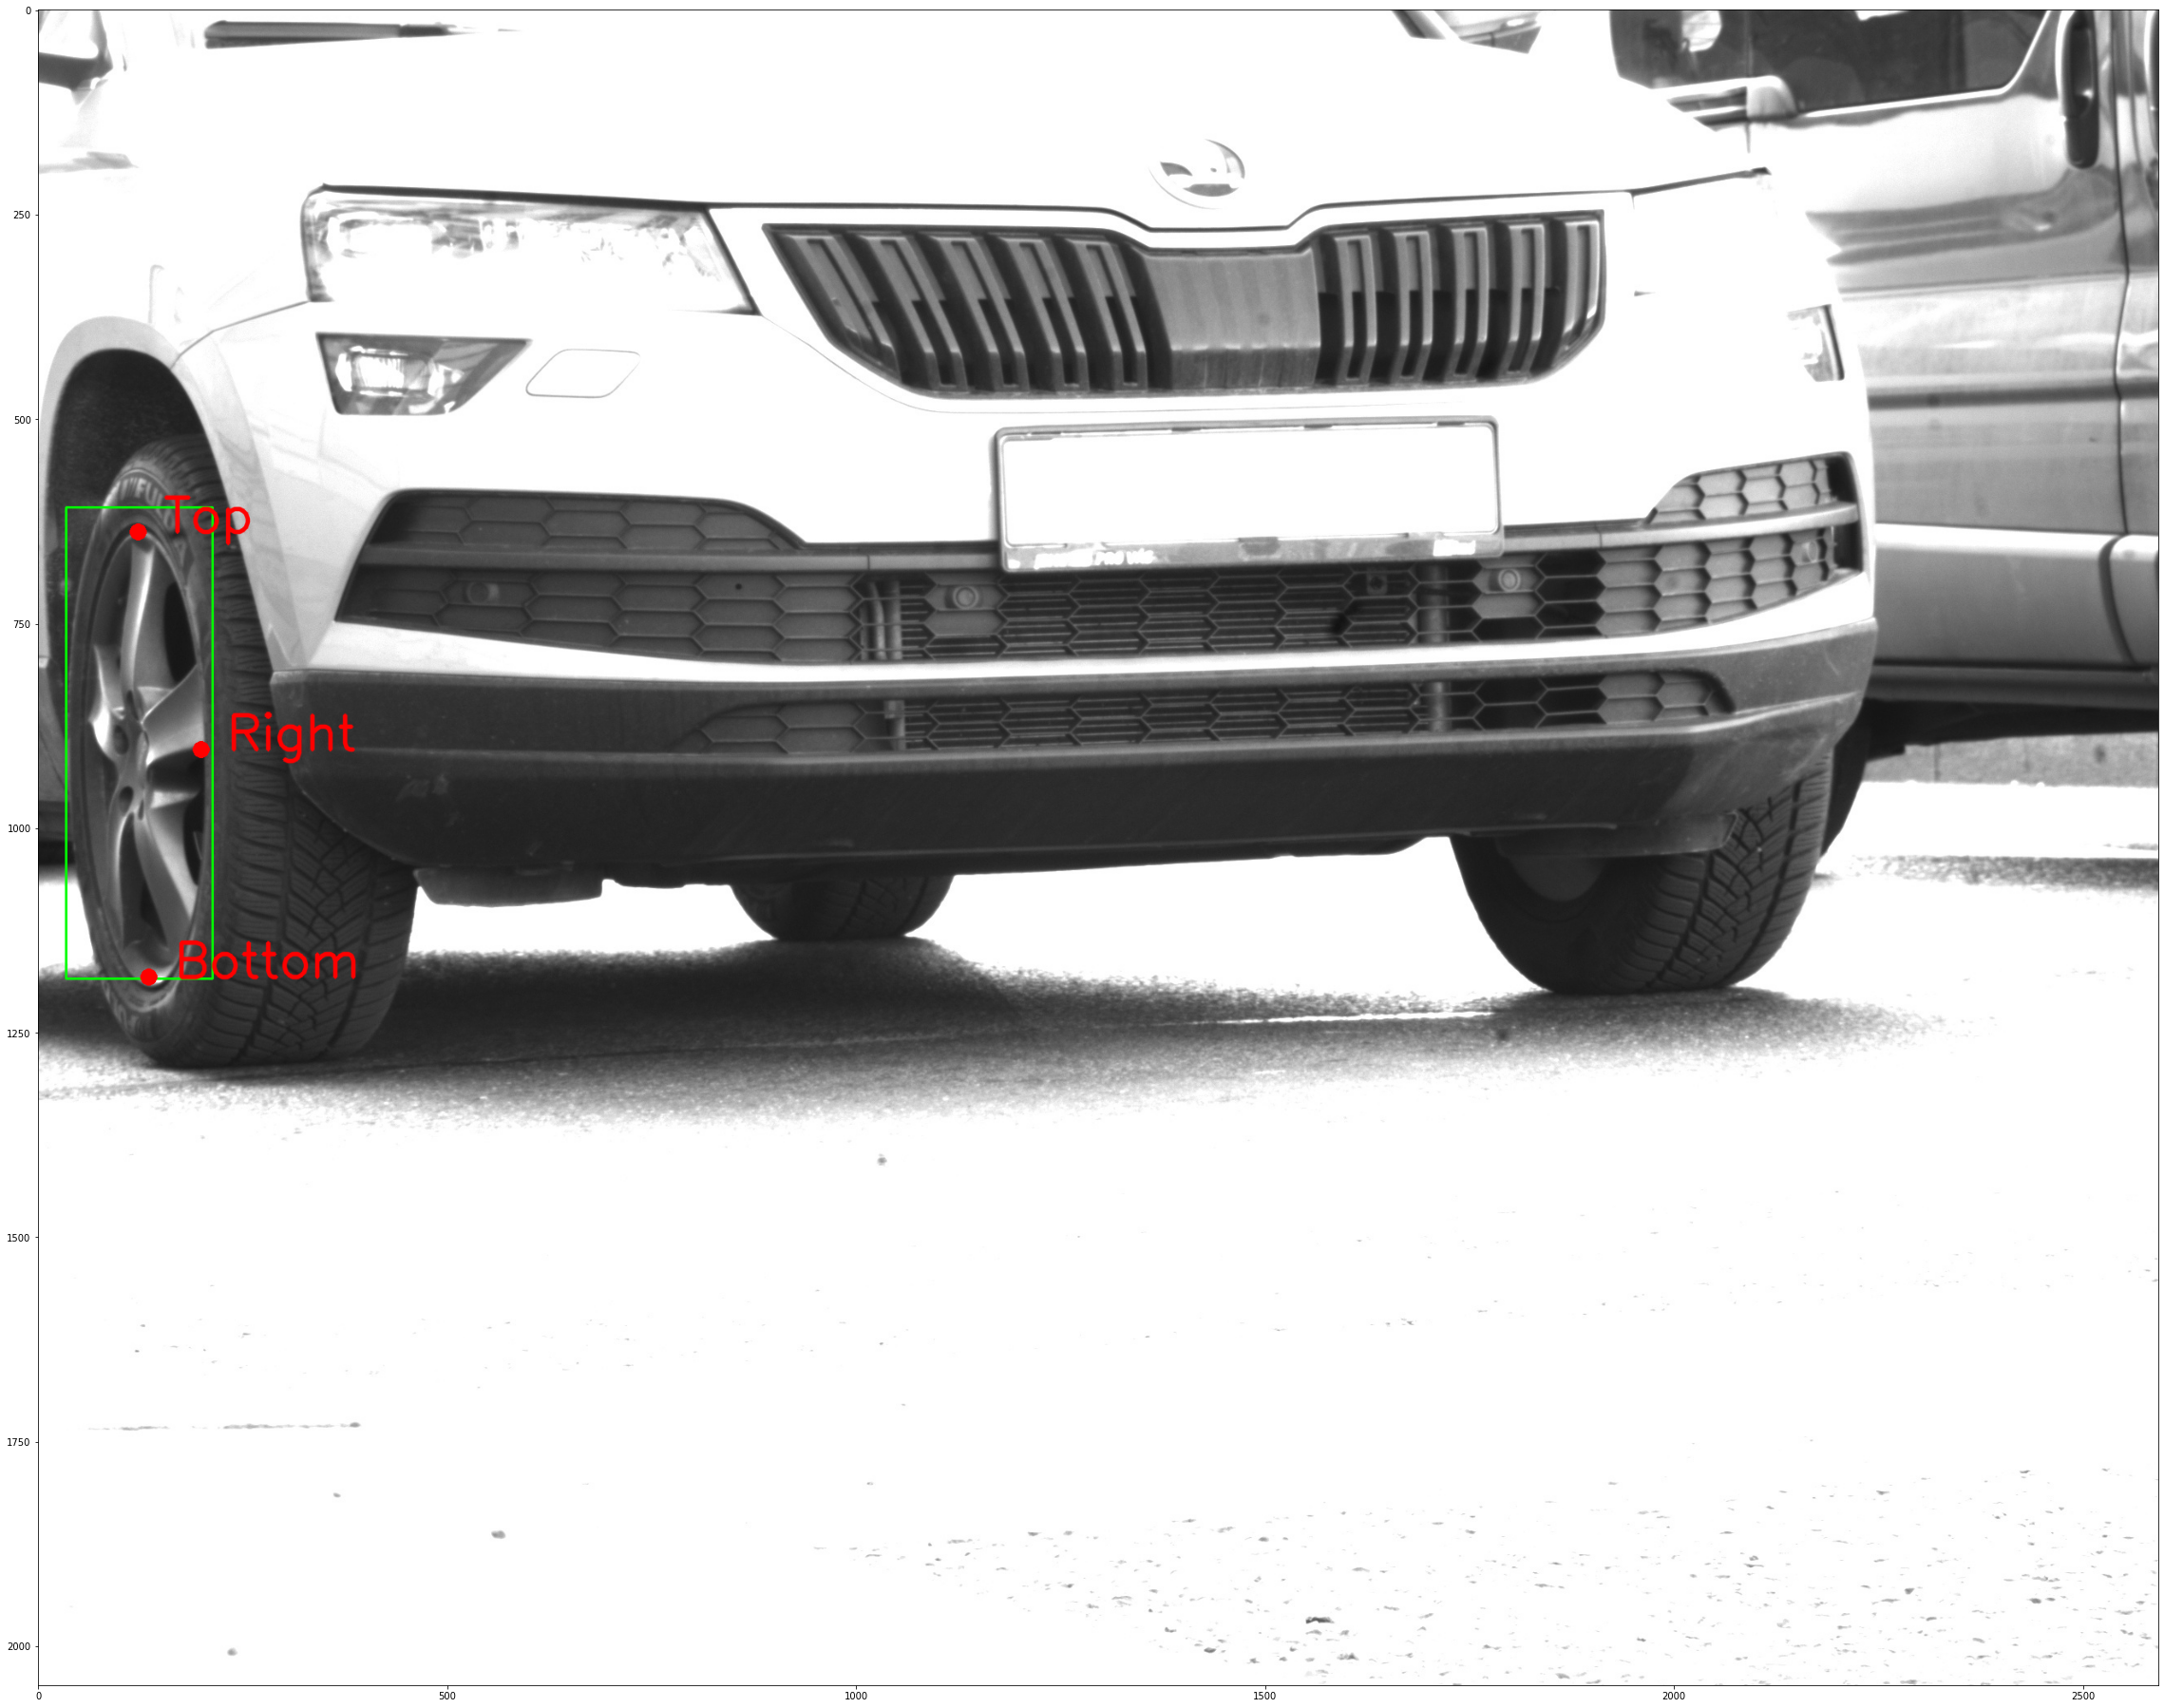

In [66]:
# Load image
image_path = 'dataset/test/images/001.jpg'

# Transform to convert the image to tensor
transform = transforms.Compose([transforms.ToTensor()])

original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = transform(Image.fromarray(original_image))

# Add a batch dimension
image = image.unsqueeze(0).to(device)

# Turn off context manager for gradient calculation (memory saving)
with torch.no_grad():
    output = model(image)

scores = output[0]['scores'].detach().cpu().numpy()

# Detections are sorted by score, highest is first
high_scores_idxs = [0]
print(f'Confidence: {scores[0]:.2f}')
# If you desire to find multiple car wheels, not just the best one, then you have to use NMS to eliminate
# overlapping objects (because second best object might be referring to the same car wheel, just with less
# confidence), see https://pytorch.org/vision/main/generated/torchvision.ops.nms.html

# Painstakingly create lists from tensors
keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
print(f'Keypoints: {keypoints}')
print(f'Bounding box: {bboxes}')

visualize(original_image, bboxes, keypoints)